# GAN + CNN  CIFAR10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import cifar10
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train / 250.0
    x_test  = x_test / 250.0
    # convert shape of x_train from (50000, 32, 32, 3) to (50000, 3072) 
    # 3072 columns per row
#     x_train = x_train.reshape(50000, 3072)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(50000, 32, 32, 3)


In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=4096))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=3072, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3072)             

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=4096,input_dim=3072))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              12587008  
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2097664   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3072)              14844672  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 14816257  
Total params: 29,660,929
Trainable params: 14,844,672
Non-trainable params: 14,816,257
_________________________________________________________________


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,32,32,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
############### 写上为什么要用CNN，用CNN在GAN的那些步骤 ###########################

In [8]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import load_model, Model

def cnn_model(train_images, train_labels,test_images,test_labels,num_classes):
    bn_axis = 3

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(3072,name="Dense_1"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    model.fit(train_images, train_labels, batch_size=64 ,epochs=10, validation_data=(test_images,test_labels) )
    
    model.save('gan_cnn_cifar10.h5')
    md=load_model('gan_cnn_cifar10.h5')
    
    m1 = Model(inputs=md.input, outputs=md.get_layer('Dense_1').output)
    cnn_imgs_train = m1.predict(train_images)
    cnn_imgs_test  = m1.predict(test_images)
    
    return cnn_imgs_train, cnn_imgs_test

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 128/128 [00:54<00:00,  2.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 20


100%|██████████| 128/128 [00:53<00:00,  2.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 31


 80%|███████▉  | 102/128 [00:42<00:10,  2.39it/s]


KeyboardInterrupt: 

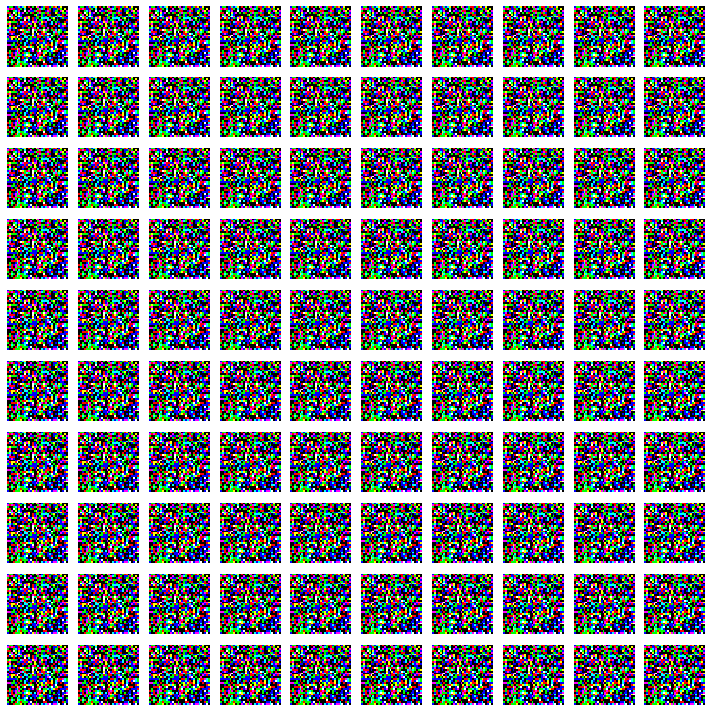

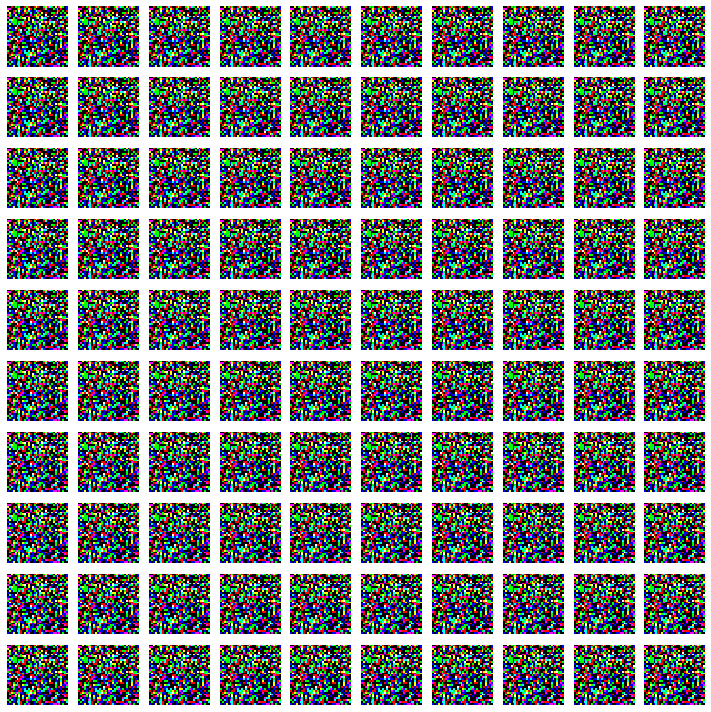

In [9]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    num_classes = 10
    
    ############################## Using CNN ????????????????????????????????###################
    X_train_res, X_test_res = cnn_model(X_train, y_train, X_test, y_test,num_classes)  # reconstruct original data by CNN
    X_train_rr = X_train_res.reshape(50000, 3072)
    X_test_rr = X_test_res.reshape(10000, 3072)
    
    batch_count = X_train_rr.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train_rr[np.random.randint(low=0,high=X_train_rr.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

training(400,128)